# Mini-projet n°1 – Chats ou Chiens ?

## 1- Analyse exploratoire du jeu de données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns # pour faire des beaux affichages
from PIL import Image

### A- Étudier la répartition par race et par type (chat/chien)

Le jeu de données est composé de 7349 lignes.
Chaque ligne a :
- un type : chat ou chien
- une race : 37 races différentes

On commence par créer un dataframe propre.

In [2]:
df = pd.read_csv(# Lecture du fichier list.txt
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         # séparateur = espaces multiples
    comment="#",                                        # ignorer les lignes commençant par #
    header=None,                                        # pas d'en-tête dans les lignes de données
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]  # noms des colonnes
)

# On rajoute des colonnes pour mieux labelliser les données
df["BREED_NAME"] = df["Image"].str.split("_").str[0]             # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})     # Chat ou chien
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg") # Et on ajoute du chemin complet vers chaque image. Il faut faire attention car les images ne sont pas dans "annotations" mais dans le dossier "images"
print(df.head())

                Image  CLASS_ID  SPECIES  BREED_ID  BREED_NAME SPECIES_NAME
0  Abyssinian_100.jpg         1        1         1  Abyssinian          Cat
1  Abyssinian_101.jpg         1        1         1  Abyssinian          Cat
2  Abyssinian_102.jpg         1        1         1  Abyssinian          Cat
3  Abyssinian_103.jpg         1        1         1  Abyssinian          Cat
4  Abyssinian_104.jpg         1        1         1  Abyssinian          Cat


On peut visualiser le nombre de chiens et de chats :

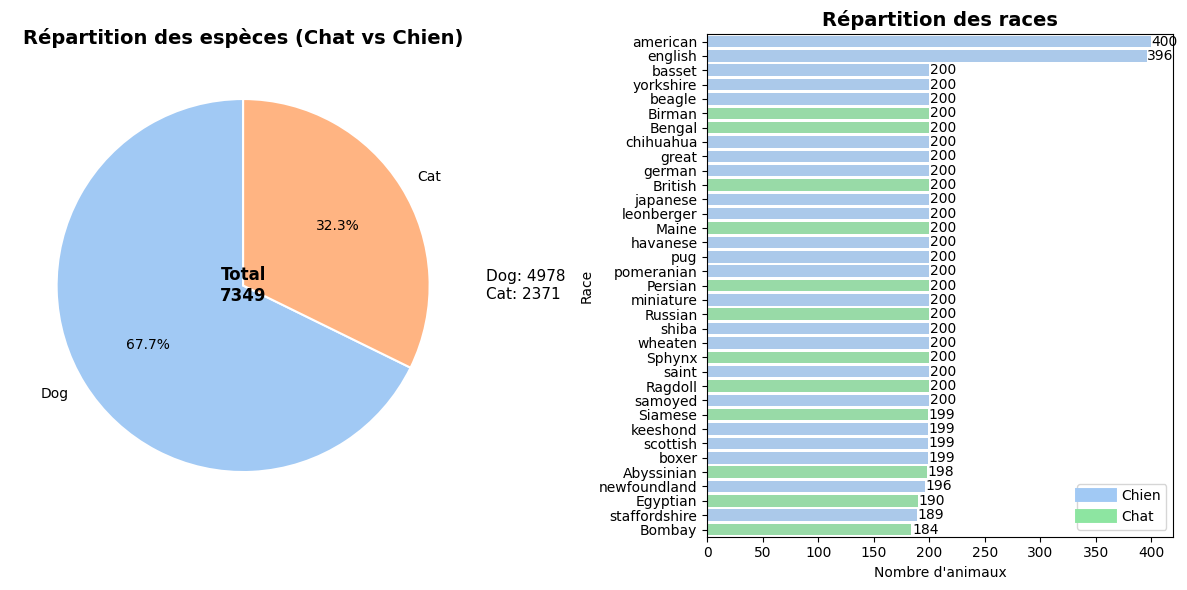

In [3]:
counts_species = df["SPECIES_NAME"].value_counts()
counts_breed = df["BREED_NAME"].value_counts()

species_per_breed = df.drop_duplicates("BREED_NAME").set_index("BREED_NAME")["SPECIES_NAME"] #j'ai voulu faire en sorte d'harmoniser les couleurs entre les deux graphiques mais je n'y arrive pas :'(
colors = {"Dog": sns.color_palette("pastel")[0],"Cat": sns.color_palette("pastel")[2]}
palette = [colors[species_per_breed[breed]] for breed in counts_breed.index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : espèces
colors_species = sns.color_palette("pastel", len(counts_species))
axes[0].pie(counts_species,labels=counts_species.index,autopct="%1.1f%%",startangle=90,colors=colors_species,wedgeprops={"edgecolor": "white", "linewidth": 1.5}) 
axes[0].set_title("Répartition des espèces (Chat vs Chien)", fontsize=14, fontweight="bold")
total = counts_species.sum()
axes[0].text(0, 0, f"Total\n{total}", ha='center', va='center', fontsize=12, fontweight='bold')
species_counts_text = "\n".join([f"{k}: {v}" for k, v in counts_species.items()]) # Ajouter le nombre exact de chaque espèce en légende
axes[0].text(1.3, 0, species_counts_text, fontsize=11, va='center')

# Deuxième graphique : races
sns.barplot(y=counts_breed.index,x=counts_breed.values,hue=counts_breed.index,palette=palette,legend=False,ax=axes[1])
axes[1].set_title("Répartition des races", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Nombre d'animaux")
axes[1].set_ylabel("Race")
for i, v in enumerate(counts_breed.values):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=10)

axes[1].legend(handles=[plt.Line2D([0], [0], color=colors["Dog"], lw=10, label="Chien"),plt.Line2D([0], [0], color=colors["Cat"], lw=10, label="Chat")],loc="lower right") #légendes chien chat en bas à droite 
plt.tight_layout()
plt.show()

on voit clairement que les deux tiers des données sont des chiens, et le tier restant est composé de chats.  
Il y a environ 200 individus de chacune des races, sauf pour les american et english où il y en a environ 400.

### B- Vérifier la cohérence et la qualité des masques de segmentation

Les masques de ségmentation se trouvent dans le dossier *oxford-iiit-pet/annotations/trimaps*.
Chaque image du jeu de données possède un masque associé qui délimite les pixels selon trois classes :
- 1 = Foreground (le corps de l'animal)
- 2 = Background (le fond de l'image)
- 3 = Not classified (on sait pas ce que sait)

Pour vérifier la cohérence et la qualité des masques, on va regarder à la main un petit échantillons, en affichant côte à côte les images et le masque associé.

nom de l'image : samoyed_66


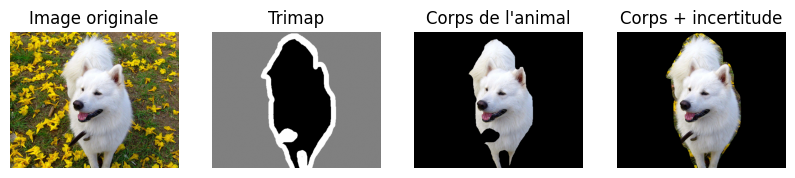

nom de l'image : basset_hound_54


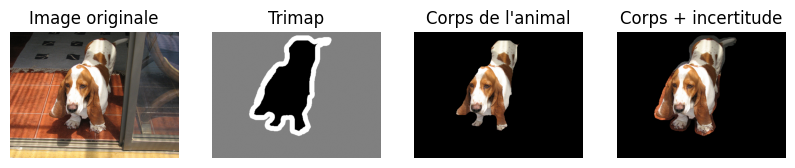

nom de l'image : Maine_Coon_17


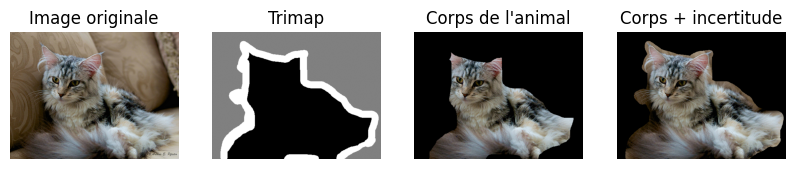

nom de l'image : keeshond_163


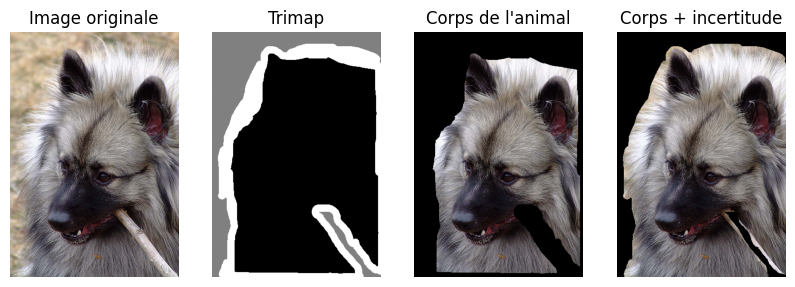

nom de l'image : Bombay_23


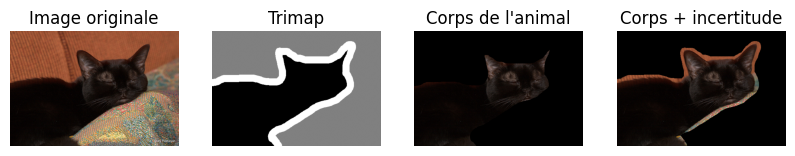

In [27]:
indices = np.random.choice(df.index, size=5, replace=False) # on choisit les indices des images que l'on va visualiser au hasard
 
img_dir = "oxford-iiit-pet/images/"                 # Chemin du répertoire qui contient les images
mask_dir = "oxford-iiit-pet/annotations/trimaps/"   # Chemin du répertoire qui contient les masques
masks = [f for f in os.listdir(mask_dir) if f.endswith(".png") and not f.startswith("._")] # On ignore les fichiers bizarres qui commencent par "._" qui sont dans le repertoire 

for indice in indices:
    image = masks[indice]
    name = os.path.splitext(image)[0]
    print("nom de l'image :",name)

    img_path = os.path.join(img_dir, name + ".jpg") # On récupère le path de l'image
    mask_path = os.path.join(mask_dir, image)       # On récupère le path du masque

    img = np.array(Image.open(img_path))            # On récupère les valeurs des pixels dans des np.array 
    mask = np.array(Image.open(mask_path))          # (on utilise la librairie PIL pour faire cela)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) 
    masked_img_moins= img.copy()
    masked_img_moins[mask != 1] = 0   # on garde seulement les pixels 1, on met tout le reste à 0 (en noir)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) et la zone d'incertitude (2)
    masked_img_plus= img.copy()
    masked_img_plus[mask == 2] = 0   # on garde seulement les pixels 1 et 3, on met les pixel 2 à 0 (en noir)

    plt.figure(figsize=(10,5))
    #On affiche nos 4 images
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(masked_img_moins)
    plt.title("Corps de l'animal")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(masked_img_plus)
    plt.title("Corps + incertitude")
    plt.axis("off")

    plt.show()

En parcourant à la main les images, les masques semblent cohérents et de plutot bonne qualité.
Il peut y avoir des confusions lorsque l'animal porte un colier par exemple (indice 4321) mais dans l'ensemble on obtient ce qu'on attend du masque.

### C- Identifier d’éventuels déséquilibres ou biais visuels

Je ne sais pas quoi dire ici

## 2- Classification Binaire

Nous cherchons à distinguer les chats des chiens à partir de leurs photos uniquement.
Pour cela, nous allons mettre en place plusieurs approches, en suivant la méthodologie vue en TP.

Un réseau de neurones convolutionnel (CNN) est particulièrement adapté pour la classification d’images, car il est capable d’apprendre automatiquement des caractéristiques visuelles comme les contours, textures ou motifs propres à chaque classe (ici chats et chiens).
Concrètement, dans ce notebook, nous proposerons trois réseaux de neurones pour réaliser cette tâche de classification :

- un CNN "naïf",
- un CNN entraîné sur un jeu de données augmenté,
- et un réseau utilisant le concept de “Transfer Learning”.

Pour ce dernier, nous utiliserons directement le jeu de données augmenté, puis nous effectuerons une phase de “Fine Tuning” afin d’en améliorer encore les performances.

Nous utiliserons TensorFlow par la suite.

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-11-13 15:27:17.938953: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 15:27:17.980419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 15:27:20.662409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Gestion des données d'entrée
Les réseaux de neurones que nous allons mettre en place nécessitent des données d’entrée de taille fixe. Nous commencerons donc par vérifier et contrôler la taille de nos images.

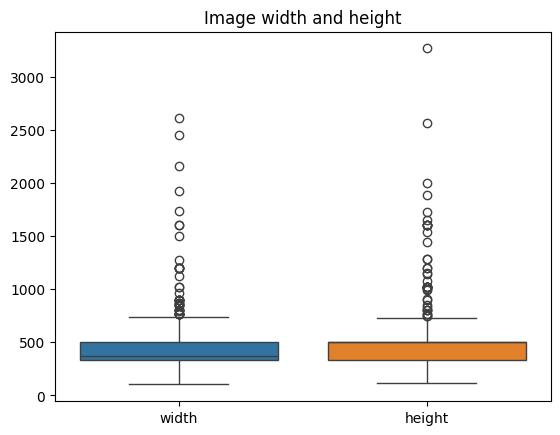

In [6]:
img_size = np.zeros((df.shape[0],2))
for i, image in enumerate(df['Image']) :
    img = img_to_array( load_img(img_dir + image) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

On constate que toutes les images n’ont pas les mêmes dimensions.
Nous allons donc devoir les redimensionner, en imposant une taille uniforme de 150 × 150 pixels.
(Il est possible de choisir une taille plus grande, 400 ou 500 par exemple, mais cela entraînerait des coûts de calcul plus élevés.)

Nous avons maintenant un choix à faire : soit redimensionner toutes les images avant de les séparer en ensembles d’entraînement, de validation et de test, soit séparer d’abord les ensembles puis redimensionner les images.
Pour rester cohérents avec la méthodologie vue en TP, nous choisissons la deuxième approche.

- On sépare en données d'entrainement, de validation et de test :

In [7]:
# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data = df[["Image", "SPECIES_NAME"]].copy() # On crée d’abord une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df = train_test_split(data, test_size=N_train, stratify=data["SPECIES_NAME"])                    # On prend 5000
test_df, validation_df = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["SPECIES_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df.shape)
print("Validation set :", validation_df.shape)
print("Test set :", test_df.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df["SPECIES_NAME"].value_counts())
print("\nValidation :", validation_df["SPECIES_NAME"].value_counts())
print("\nTest :", test_df["SPECIES_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : SPECIES_NAME
Dog    3522
Cat    1678
Name: count, dtype: int64

Validation : SPECIES_NAME
Dog    678
Cat    322
Name: count, dtype: int64

Test : SPECIES_NAME
Dog    778
Cat    371
Name: count, dtype: int64


- On redimensionne nos images :

In [8]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1149 validated image filenames belonging to 2 classes.


Le réseau que nous allons définir est un CNN “naïf”, simple, constitué de plusieurs couches convolutionnelles et de pooling, suivi de couches entièrement connectées. Voici la logique derrière sa construction :
- Couche d’entrée (Input) : elle prend des images de taille (img_width, img_height, 3) — 3 canaux pour les couleurs RGB.
- Couches convolutionnelles (Conv2D) : elles détectent progressivement des motifs de plus en plus complexes dans les images.
- Couches de pooling (MaxPooling2D) : elles réduisent la taille des cartes de caractéristiques tout en conservant les informations importantes, ce qui diminue le coût de calcul et évite le surapprentissage.
- Couches denses (Dense) : après avoir aplati les cartes de caractéristiques avec Flatten(), ces couches permettent au réseau d’apprendre des combinaisons non linéaires pour la classification finale.
- Dropout : cette couche de régularisation permet de réduire le risque de surapprentissage en désactivant aléatoirement certaines neurones pendant l’entraînement.
- Couche de sortie : une seule unité avec une activation sigmoid, adaptée à la classification binaire (chat ou chien).

On fait une fonction car on aura besoin d'initialiser un réseau à nouveau, ça économise des lignes :)

The model we define is composed of 3 convolution blocks with the following form:  
* A $\texttt{Conv2D}$ layer with $3\times3$ filters and a $\texttt{Relu}$ activation function.<br>
  The first layer has 32 convolution filters, the second 64, and the third 96.  
* A $\texttt{MaxPooling}$ layer with a $2\times2$ window.

Followed by:  
* A $\texttt{Flatten}$ layer.  
* A $\texttt{Dense}$ layer with 64 neurons and a $\texttt{Relu}$ activation function.  
* A $\texttt{Dropout}$ layer with a 50% drop rate.  
* A $\texttt{Dense}$ layer with 1 neuron and a $\texttt{sigmoid}$ activation function.


In [9]:
def cnn_simple(nom):
    cnn = Sequential(name=nom)
    cnn.add(Input(shape=(img_width,img_height,3)))
    cnn.add(Conv2D(32, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Flatten())
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))
    return cnn

In [10]:
cnn_naif=cnn_simple("cnn_naif")
cnn_naif.summary()                  # Affichage de nos couches et du nombre de paramètres

I0000 00:00:1763044058.038681   13009 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 848 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


Model: "cnn_naif"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,529 (7.06 MB)

 Trainable params: 1,850,529 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle
Nous faisons face à un problème de classification binaire (chat vs chien).
Pour ce type de tâche, il est naturel de choisir comme fonction de perte (loss) la binary_crossentropy, qui mesure la distance entre les probabilités prédites par le réseau et les labels réels.

L’entraînement d’un réseau de neurones implique également le choix d’un optimiseur, ici on choisit Adam, avec un taux d’apprentissage (learning_rate) adapté. Nous allons entraîner notre modèle pendant un nombre d’époques défini (ici on prend epochs = 10).

La fonction suivante permet d’entraîner un CNN donné et de mesurer le temps d’apprentissage :

In [11]:
import time
epochs = 10

def Entrainement(cnn,epochs,train_generator):
    print("Entrainement de ",cnn.name)
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics = ['accuracy'])

    t_learning_cnn = time.time()
    
    cnn_history = cnn.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_cnn = time.time() - t_learning_cnn
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn))
    
    return t_learning_cnn, cnn_history, t_learning_cnn

In [12]:
t_learning_cnn_naif, cnn_naif_history, t_learning_cnn_naif = Entrainement(cnn_naif,epochs,train_generator)

Entrainement de  cnn_naif
Epoch 1/10


/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-11-13 15:27:39.444245: I external/local_xla/xla/service/service.cc:163] XLA service 0x7740a800b6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-13 15:27:39.444284: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation, Compute Capability 8.9
2025-11-13 15:27:39.467848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-13 15:27:39.641607: I external/local_xla/xla/stream

  5/260 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7587 - loss: 0.5950

I0000 00:00:1763044062.538933   13139 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.6794 - loss: 0.6015 - val_accuracy: 0.6990 - val_loss: 0.5742
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7104 - loss: 0.5332 - val_accuracy: 0.7310 - val_loss: 0.5132
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7517 - loss: 0.4986 - val_accuracy: 0.7460 - val_loss: 0.4953
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.7827 - loss: 0.4584 - val_accuracy: 0.7540 - val_loss: 0.4936
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8112 - loss: 0.4166 - val_accuracy: 0.7620 - val_loss: 0.4868
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8302 - loss: 0.3741 - val_accuracy: 0.7850 - val_loss: 0.4665
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.8412 - loss: 0.3453 - val_accuracy: 0.7780 - val_loss: 0.4618
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.8667 - loss: 0.3080 - val_accurac

On crée les fonctions suivantes pour analyser les performances de notre réseau

In [13]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(validation_generator, verbose=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    plot_training_analysis(cnn_history)
    return t_prediction_cnn

260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9546 - loss: 0.1534
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7780 - loss: 0.5284
Train accuracy: 0.9546154141426086
Validation accuracy: 0.777999997138977
Time Prediction: 13.58 seconds


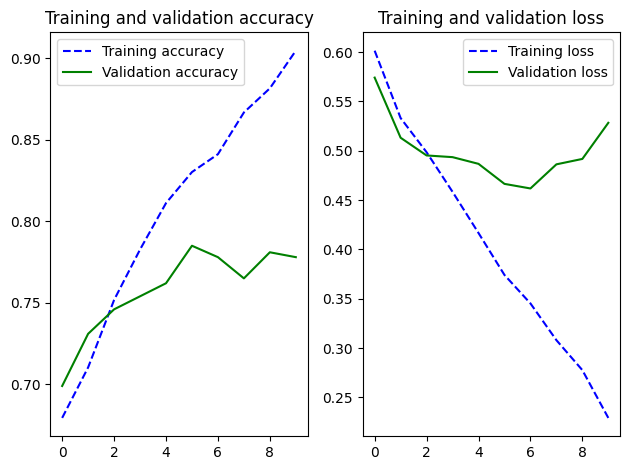

In [14]:
t_prediction_cnn_naif = Analyse_resultats(cnn_naif,cnn_naif_history)

Nous obtenons des résultats corrects, mais nous observons un cas clair de sur-apprentissage (overfitting) : le modèle est très performant sur les données d’entraînement, mais il a du mal à généraliser sur de nouvelles images.

Pour y remédier, nous allons mettre en place une nouvelle approche.

Une solution efficace pour contrer le sur-apprentissage est l’augmentation de données (data augmentation).
Cette technique consiste à transformer les images existantes pour générer de nouvelles images artificiellement : par exemple en appliquant des rotations, décalages, zooms, retournements, etc.
L’idée est d’augmenter la diversité du jeu de données, ce qui aide le réseau à apprendre des caractéristiques plus robustes et à mieux généraliser.

Nous entraînerons ensuite notre deuxième CNN sur ce jeu de données augmenté.

- On commence par générer le nouveau jeu de données :

In [15]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    img_dir,
    x_col ='Image',
    y_col ='SPECIES_NAME',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.


- Puis on initialise le nouveau CNN qu'on vient entrainer sur le nouveau jeu de données :

In [16]:
cnn_data_augmented = cnn_simple("cnn_data_augmented") # On initialise un nouveau réseau (identique au dernier)

cnn_data_augmented.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

t_learning_cnn_data_augmented, cnn_data_augmented_history, t_learning_cnn_data_augmented = Entrainement(cnn_data_augmented,epochs,train_generator_augmented) # on va l'entrainer avec les données augmentées cette fois

Entrainement de  cnn_data_augmented
Epoch 1/10


/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6760 - loss: 0.6162 - val_accuracy: 0.6780 - val_loss: 0.5725
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.6783 - loss: 0.5942 - val_accuracy: 0.6780 - val_loss: 0.5917
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.6894 - loss: 0.5781 - val_accuracy: 0.7200 - val_loss: 0.5203
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.6929 - loss: 0.5698 - val_accuracy: 0.7130 - val_loss: 0.5140
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7083 - loss: 0.5564 - val_accuracy: 0.7340 - val_loss: 0.5079
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7135 - loss: 0.5618 - val_accuracy: 0.7270 - val_loss: 0.5281
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.7179 - loss: 0.5554 - val_accuracy: 0.7510 - val_loss: 0.4896
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.7258 - loss: 0.5474 - val_accura

- On observe que les performances sont meilleures :

260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7829 - loss: 0.4729
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7760 - loss: 0.4737
Train accuracy: 0.7828845977783203
Validation accuracy: 0.7760000228881836
Time Prediction: 13.68 seconds


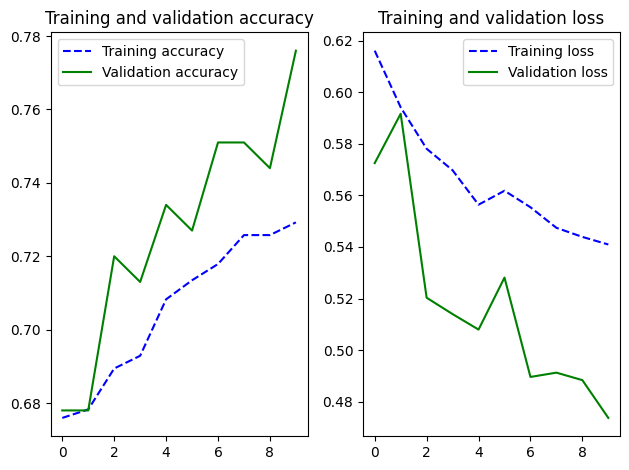

In [17]:
t_prediction_cnn_data_augmented = Analyse_resultats(cnn_data_augmented,cnn_data_augmented_history)

Cependant le modèle met beaucoup plus de temps à s'entrainer. On obtient des résultats corrects, mais si on veut faire mieux, il faudrait beaucoup plus de données à notre disposition, ainsi que beaucoup plus de temps.  

La dernière solution pour avoir une meilleure précision est d'utiliser le **Transfer Learning**. On va s'aider d'un réseau pré-entrainé (ici VGG16) et on va y accroché notre propre *MLP classifier*.
On peut aussi combiner cette approche avec l'augmentation de données. Nous avons vu dans le TP que c'est ce qui donne les meilleurs résultats, nous allons donc directement mettre en place cela. 

In [18]:
from tensorflow.keras.applications import VGG16 #on importe VGG16

#Contient la base de VGG
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)
#conv_base.summary()

In [19]:
vgg_combined = Sequential(name="VGG16_data_augmented")
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On ne veut surtout pas toucher aux paramètres de VGG (on changera cela quand on fera le fine-tuning)
vgg_combined.summary()

Model: "VGG16_data_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

- On entraine notre réseau sur le jeu de données augmenté :

In [20]:
t_learning_vgg_combined_augmented, vgg_combined_history, t_learning_vgg_combined = Entrainement(vgg_combined,epochs,train_generator_augmented)

Entrainement de  VGG16_data_augmented
Epoch 1/10


2025-11-13 15:34:46.496716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 8 bytes spill stores, 8 bytes spill loads

2025-11-13 15:34:46.496972: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 52 bytes spill stores, 52 bytes spill loads

2025-11-13 15:34:46.957904: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 235.87MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-13 15:34:47.036105: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 235.87MiB with freed_by_count=0. The caller indicates that 

260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.7979 - loss: 0.4335 - val_accuracy: 0.8580 - val_loss: 0.3037
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.8419 - loss: 0.3656 - val_accuracy: 0.8880 - val_loss: 0.2421
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.8587 - loss: 0.3315 - val_accuracy: 0.8780 - val_loss: 0.2615
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.8510 - loss: 0.3238 - val_accuracy: 0.8970 - val_loss: 0.2509
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.8692 - loss: 0.2987 - val_accuracy: 0.9090 - val_loss: 0.2125
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.8706 - loss: 0.3014 - val_accuracy: 0.8980 - val_loss: 0.2326
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.8694 - loss: 0.2995 - val_accuracy: 0.9070 - val_loss: 0.2176
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.8777 - loss: 0.2835 - val_accura

260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1752
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9240 - loss: 0.1955
Train accuracy: 0.9305769205093384
Validation accuracy: 0.9240000247955322
Time Prediction: 14.76 seconds


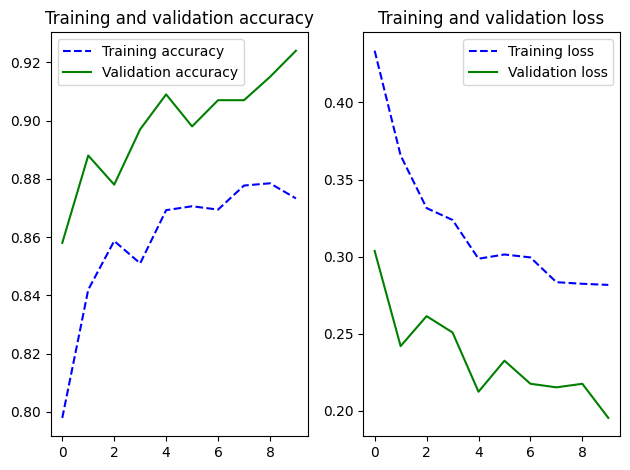

In [21]:
t_prediction_vgg_combined_augmented = Analyse_resultats(vgg_combined,vgg_combined_history)

Les résultats qu'on obtient avec le Transfer Learning sont bons.

### Fine Tuning
Pour améliorer encore davantage la précision, nous allons maintenant effectuer une étape de Fine Tuning.

Le Fine Tuning consiste à défiger certaines couches du modèle pré-entraîné afin de réentraîner partiellement le réseau sur notre propre jeu de données.
L’idée est de permettre au modèle d’adapter ses représentations internes (les filtres appris dans les couches profondes) à notre problème spécifique, tout en conservant les connaissances générales issues de l’entraînement initial.

In [22]:
# On recrée la même architecture que vgg_combined mais on rename
vgg_finetuned = tf.keras.Sequential(name="VGG16_data_augmented_finetuned")
vgg_finetuned.add(Input(shape=(img_width, img_height, 3)))
vgg_finetuned.add(conv_base)
vgg_finetuned.add(Flatten())
vgg_finetuned.add(Dense(256, activation='relu'))
vgg_finetuned.add(Dense(1, activation='sigmoid'))

conv_base.trainable = True # On rend la base convolutive entraînable
for layer in conv_base.layers[:15]: # On bloque les 15 premières couches (celles qui apprennent des caractéristiques générales)
    layer.trainable = False

vgg_finetuned.set_weights(vgg_combined.get_weights()) # On copie les poids du modèle précédent

vgg_finetuned.summary()


Model: "VGG16_data_augmented_finetuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [23]:
epochs = 5

vgg_finetuned.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Reduced learning rates to avoid smashing everything and risking overfitting
    metrics = ['accuracy']
)

t_learning_vgg_finetuned = time.time()
vgg_finetuned_history = vgg_finetuned.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_finetuned = time.time() - t_learning_vgg_finetuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_finetuned))

Epoch 1/5


2025-11-13 15:39:24.018608: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_968', 4 bytes spill stores, 4 bytes spill loads



260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - accuracy: 0.8406 - loss: 0.3683 - val_accuracy: 0.9150 - val_loss: 0.1865
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9073 - loss: 0.2287 - val_accuracy: 0.9480 - val_loss: 0.1238
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.9223 - loss: 0.1894 - val_accuracy: 0.9570 - val_loss: 0.1098
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.9367 - loss: 0.1546 - val_accuracy: 0.9520 - val_loss: 0.1200
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.9460 - loss: 0.1374 - val_accuracy: 0.9580 - val_loss: 0.1261
Learning time for 5 epochs : 136 seconds


260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9771 - loss: 0.0559
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9580 - loss: 0.1261
Train accuracy: 0.9771153926849365
Validation accuracy: 0.9580000042915344
Time Prediction: 14.00 seconds


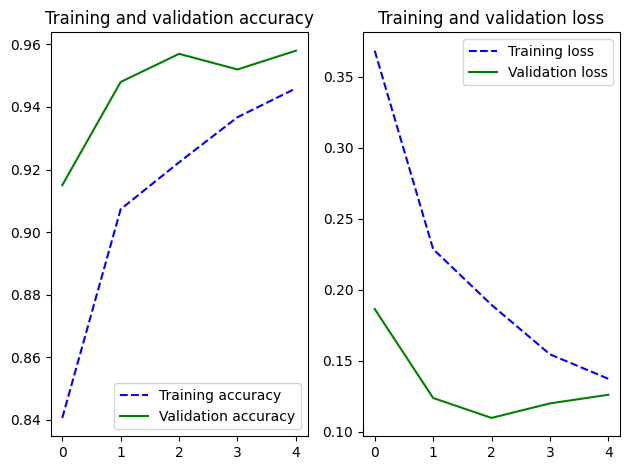

13.997021913528442

In [24]:
Analyse_resultats(vgg_finetuned,vgg_finetuned_history)

On obtient maintenant de très bon résultats. Si on le souhaite, on pourrait continuer le fine-tuning mais ce n'est pas necessaire. 

### Comparaison des modèles

In [25]:
def Eval_Test(cnn):
    print("-------------",cnn.name,"-------------")
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    loss, acc = cnn.evaluate(test_generator)
    print(f"loss = {loss}")
    print(f"accuracy = {acc}\n")

In [26]:
Eval_Test(cnn_naif)
Eval_Test(cnn_data_augmented)
Eval_Test(vgg_combined)
Eval_Test(vgg_finetuned)

------------- cnn_naif -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8120 - loss: 0.4874
loss = 0.48735663294792175
accuracy = 0.8120104670524597

------------- cnn_data_augmented -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7815 - loss: 0.4682
loss = 0.4682462215423584
accuracy = 0.7815491557121277

------------- VGG16_data_augmented -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9547 - loss: 0.1138
loss = 0.11375068873167038
accuracy = 0.9547432661056519

------------- VGG16_data_augmented_finetuned -------------
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9617 - loss: 0.0991
loss = 0.0991438776254654
accuracy = 0.9617058038711548



Faire un petit texte qui parle des résultats

## 3- Classification Fine

## 4- Segmentation des animaux

## 5- Analyse comparative